In [ ]:
import tensorflow as tf
import keras
from keras import layers as ls
import pandas as pd

In [ ]:
data_link = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/38817/4247893/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1663773765&Signature=bZuyhf0WTj3GVhOhZ8HLznXrPGKmkYTjmPOGGtybonyj3IYjirG3PN4JwGrpGWiUd0Oh9f4bL16ryaqjlhlKhwLHZmOY9r7Vm6z3OcMYQvuLN2G%2FymuFMgnWA8Dyhju5sza72lpC4kiVnqQ705%2Fa%2F5opMfuHVGD94f5YO5T%2B5aBS%2Fx9FkcPoQy5GObc%2FOqeWN7raKGTlYQLjn1s3YikAdQSiBmGNRpXcsUJ1LlOGXQWFnNyVQNms%2F997FyWT3YGOx7vLVZVRwSjOj5BHwFw065%2FvLyCSi%2FDCbOvn7l1mTW8xwxGr8FtaWCAGyWTALjkPI8%2F5bI86jzlurpdku0ckHQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dieee-final-round.zip'
data_path= tf.keras.utils.get_file('data.zip',data_link,extract=True,cache_dir='.')
data_path

471359488/471343895 [==============================] - 5s 0us/step


'./datasets/data.zip'

In [ ]:
import os
train_images_path = '/content/datasets/train_features/train_features'
test_images_path = '/content/datasets/test_features/test_features'
train_set = pd.read_csv('/content/datasets/train_set.csv')
test_set = pd.read_csv('/content/datasets/test_set.csv')
train_labels = pd.read_csv('/content/datasets/train_labels.csv')
train_labels.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
COLS = list(train_labels.columns) # Getting the categories names to get the prediction outputs later
COLS.remove('id') 
train_df = train_labels.copy()
train_df = train_df[[c for c in COLS ]]
train_labels['label_as_one_hot'] = train_df.apply(lambda x:np.array(x,dtype=np.int64).tolist(),axis=1)

train_labels['pathes'] = train_labels['id'].apply(lambda x:os.path.join(train_images_path,x+'.jpg'))
train_df = train_labels[['pathes','label_as_one_hot']]
train_df

,pathes,label_as_one_hot
0,/content/datasets/train_features/train_feature...,"[0, 1, 0, 0, 0, 0, 0, 0]"
1,/content/datasets/train_features/train_feature...,"[0, 0, 0, 0, 0, 0, 1, 0]"
2,/content/datasets/train_features/train_feature...,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,/content/datasets/train_features/train_feature...,"[0, 0, 0, 0, 0, 1, 0, 0]"
4,/content/datasets/train_features/train_feature...,"[0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...
12724,/content/datasets/train_features/train_feature...,"[0, 0, 1, 0, 0, 0, 0, 0]"
12725,/content/datasets/train_features/train_feature...,"[0, 0, 0, 0, 0, 1, 0, 0]"
12726,/content/datasets/train_features/train_feature...,"[0, 0, 0, 1, 0, 0, 0, 0]"
12727,/content/datasets/train_features/train_feature...,"[0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
def load_process_image(image_path,label):
  img_file = tf.io.read_file(image_path)
  img = tf.io.decode_jpeg(img_file,channels=3)
  img = img[:-32] # cut the unwanted 
  img = tf.image.resize(img,IMG_SIZE)
  return img,tf.cast(label,tf.int32)
img_pathes,labels = list(train_df['pathes']),list(train_df['label_as_one_hot'])
def make_ds(img_pathes,labels,batch_size=64,shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((img_pathes,labels))
  ds = ds.map(load_process_image,num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.batch(batch_size)
  if shuffle:
    ds = ds.shuffle(batch_size*10)
  return ds.prefetch(tf.data.AUTOTUNE)

train_size = int(len(img_pathes)*0.85)
train_img_pathes = img_pathes[:train_size]
train_labels = labels[:train_size]
val_img_pathes = img_pathes[train_size:]
val_labels = labels[train_size:]

print(f"Train_size:{train_size}, val_size:{len(img_pathes)-train_size}")  

Train_size:10819, val_size:1910


In [ ]:
import cv2
from tqdm import tqdm
import os
IMG_SIZE = (224,224)
if not os.path.exists('tfrecs'):
   os.mkdir('tfrecs')
def image_feature(image):
  return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(image).numpy()])
    )  
def label_feature(label):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=label))


def get_img_brightness(img):
    hsl = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    lval = np.mean(hsl[:,:,1])
    return lval

def create_example(img_path,label):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img,channels=3)[:-32]
  img = tf.py_function(transform_img,[img],tf.uint8)
  feature={'image':image_feature(img),
           'label':label_feature(label)}
  return tf.train.Example(features=tf.train.Features(feature=feature))
clahe = cv2.createCLAHE(clipLimit = 2)  

def transform_img(img):
    img= img.numpy()
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
    lab = list(cv2.split(lab))
    lab[0]= clahe.apply(lab[0])
    lab = cv2.merge(lab)
    return cv2.cvtColor(lab,cv2.COLOR_LAB2RGB) #image
def read_example(example):
  desc = {
      'image':tf.io.FixedLenFeature([],tf.string),
      'label':tf.io.FixedLenFeature([len(COLS)],tf.int64)}
  feats = tf.io.parse_single_example(example,desc)
  img = feats.pop('image')
  img = tf.io.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,IMG_SIZE)
  return img,feats['label']


def create_tf_record(img_pathes,labels,file_name):
  with tf.io.TFRecordWriter(file_name) as writer:
    for idx in tqdm(range(len(img_pathes))):
      example = create_example(img_pathes[idx],labels[idx])
      writer.write(example.SerializeToString())

train_path = '/content/tfrecs/train_ds.tfrec'
val_path = '/content/tfrecs/val_ds.tfrec'
create_tf_record(train_img_pathes,train_labels,train_path)
create_tf_record(val_img_pathes,val_labels,val_path)

100%|██████████| 1910/1910 [00:26<00:00, 73.12it/s]


In [ ]:

def load_ds_from_tfrecords(ds_filename,batch_size=64,shuffle=100):
  ds = tf.data.TFRecordDataset(ds_filename)
  ds = ds.map(read_example,num_parallel_calls=tf.data.AUTOTUNE)
  ds = ds.shuffle(batch_size*shuffle)
  ds = ds.batch(batch_size)

  return ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
import matplotlib.pyplot as plt

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]
    images_one,images_two = tf.cast(images_one,tf.float32),tf.cast(images_two,tf.float32)
    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = tf.cast(labels_one,tf.float32) * y_l + tf.cast(labels_two,tf.float32) * (1 - y_l)
    return (images, labels)

In [ ]:
train_ds1 = load_ds_from_tfrecords(train_path,64,10)
train_ds2 = load_ds_from_tfrecords(train_path,64)
train_ds = tf.data.Dataset.zip((train_ds1,train_ds2))
train_ds = train_ds.map(mix_up,num_parallel_calls=tf.data.AUTOTUNE)
val_ds = load_ds_from_tfrecords(val_path,32)

In [ ]:
import matplotlib.pyplot as plt
for i in train_ds1:
  print(i)
  break

(<tf.Tensor: shape=(64, 224, 224, 3), dtype=float32, numpy=
array([[[[1.66015305e+02, 2.52019135e+02, 2.38827805e+02],
         [1.60172195e+02, 2.29366699e+02, 2.19635208e+02],
         [2.01401138e+02, 2.54712372e+02, 2.52693878e+02],
         ...,
         [0.00000000e+00, 6.21429443e+00, 1.62142944e+01],
         [4.17797947e+00, 1.71779804e+01, 2.61779804e+01],
         [2.67276287e+00, 1.56727629e+01, 2.46727619e+01]],

        [[1.84394135e+02, 2.54894775e+02, 2.42207901e+02],
         [1.76563782e+02, 2.49782516e+02, 2.37279327e+02],
         [1.79232132e+02, 2.47205978e+02, 2.35508911e+02],
         ...,
         [0.00000000e+00, 8.61032391e+00, 1.86103230e+01],
         [1.11099041e+00, 1.39821949e+01, 2.29821949e+01],
         [4.27264690e-01, 1.22677784e+01, 2.12677784e+01]],

        [[2.04491699e+02, 2.46245529e+02, 2.39832901e+02],
         [1.41200882e+02, 2.17408798e+02, 1.99224472e+02],
         [8.66613617e+01, 1.63070801e+02, 1.44456650e+02],
         ...,
         

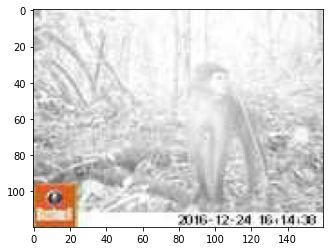

In [ ]:
img = tf.io.decode_jpeg(tf.io.read_file('/content/datasets/test_features/test_features/ZJ000012.jpg'),channels=3)
plt.imshow(img)

215.56197916666667


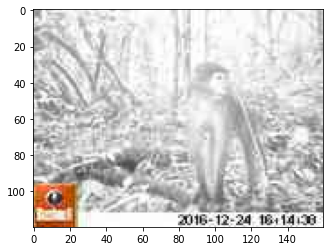

In [ ]:
print(get_img_brightness(img.numpy()))
plt.imshow(transform_img(img))

In [ ]:
data_aug = tf.keras.Sequential([ls.Input((224,224,3)),ls.RandomRotation(0.3),
                                ls.RandomFlip(),ls.RandomTranslation((0.1,0.2),(0.15,0.3))])


In [ ]:
# apply the data augmentation on training dataset
train_ds1 = train_ds1.map(lambda x,y:(data_aug(x),y),num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def sep_model(img_size,num_classes,filters=[512,256,128,64,32,16],drop=0.5,act='relu'):
  inputs = ls.Input(shape=(img_size,img_size,3))
  x = ls.Rescaling(1/255.0)(inputs)
  x = ls.Conv2D(filters[0],kernel_size=9)(x)
  x = ls.Dropout(drop)(x)
  for filt in filters:
    res = x 
    x = ls.BatchNormalization()(x)
    x = ls.Activation(act)(x)
    x = ls.SeparableConv2D(filt,3,padding='same')(x)

    x = ls.BatchNormalization()(x)
    x = ls.Activation(act)(x)
    x = ls.SeparableConv2D(filt,3,padding='same')(x)

    x = ls.MaxPool2D(3,(2,2),padding='same')(x)
    res = ls.Conv2D(filt,1,strides=2,padding='same')(res)
    x = ls.add([x,res])
  x = ls.GlobalAveragePooling2D()(x)
  x = ls.Dropout(drop)(x)
  out = ls.Dense(num_classes,activation='softmax')(x)
  return tf.keras.Model(inputs,out)  
Model = sep_model(224,len(COLS))
Model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 216, 216, 51  124928      ['rescaling[0][0]']              
                                2)                                                                
                                                                                            

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['tf.math.subtract[0][0]']   

In [ ]:
loss_eval = tf.losses.CategoricalCrossentropy()
@tf.function
def test_step(model,img,label):
  preds = model(img)
  l = loss_eval(label,preds)
  return l
def eval(model,ds):
  l =[]
  for img,label in val_ds:
    l.append(test_step(model,img,label))
  return sum(l)/len(l)


In [ ]:
!pip install -q -U tensorflow_addons

     |████████████████████████████████| 1.1 MB 39.3 MB/s 


In [ ]:
import tensorflow_addons as tfa
steps_per_epoch = train_size//64
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
    maximal_learning_rate=2e-3,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
Model.compile(loss=loss_eval,optimizer=tf.optimizers.Adam(5e-4),metrics=['accuracy'])
model.compile(loss=loss_eval,optimizer=tf.optimizers.Adam(5e-4),metrics=['accuracy'])

In [ ]:
filepath ='weights_1'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor= 'val_loss',
    save_weights_only = True,mode='min'
)
hist=model.fit(train_ds2,validation_data=val_ds,epochs=10,callbacks=[callback])

Epoch 1/10
170/170 [==============================] - 60s 266ms/step - loss: 1.0009 - accuracy: 0.6361 - val_loss: 0.7705 - val_accuracy: 0.7246
Epoch 2/10
170/170 [==============================] - 55s 264ms/step - loss: 0.5983 - accuracy: 0.7864 - val_loss: 0.6940 - val_accuracy: 0.7681
Epoch 3/10
170/170 [==============================] - 55s 264ms/step - loss: 0.4132 - accuracy: 0.8516 - val_loss: 0.5607 - val_accuracy: 0.8241
Epoch 4/10
170/170 [==============================] - 56s 264ms/step - loss: 0.3152 - accuracy: 0.8854 - val_loss: 0.5807 - val_accuracy: 0.8204
Epoch 5/10
170/170 [==============================] - 56s 265ms/step - loss: 0.2403 - accuracy: 0.9166 - val_loss: 0.6501 - val_accuracy: 0.8204
Epoch 6/10
170/170 [==============================] - 55s 264ms/step - loss: 0.1869 - accuracy: 0.9322 - val_loss: 0.7526 - val_accuracy: 0.8262
Epoch 7/10
170/170 [==============================] - 56s 267ms/step - loss: 0.1517 - accuracy: 0.9512 - val_loss: 0.7104 - val_ac

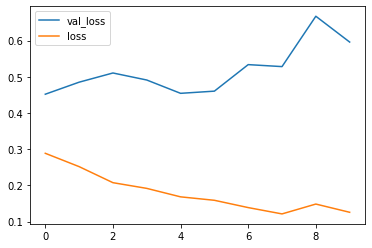

In [ ]:
import numpy as np
epochs = np.arange(len(hist.history['val_loss']))
plt.plot(epochs,hist.history['val_loss'])
plt.plot(epochs,hist.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

In [ ]:
#model.load_weights('weights')
for layer in model.layers[-20:]:
  if not isinstance(layer,ls.BatchNormalization):
    layer.trainable=True
model.compile(loss=loss_eval,optimizer=tf.optimizers.Adam(5e-4),metrics=['accuracy'])        
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 224, 224, 3)  0          ['input_5[0][0]']                
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 224, 224, 3)  0          ['tf.math.truediv_1[0][0]']      
 )                                                                                                
                                                                                            

In [ ]:

model.evaluate(val_ds)

40/40 [==============================] - 6s 67ms/step - loss: 0.4429 - accuracy: 0.8955


[0.4429180324077606, 0.89552241563797]

In [ ]:
model.load_weights('weights_')
model.evaluate(val_ds)

40/40 [==============================] - 6s 68ms/step - loss: 0.4407 - accuracy: 0.8971


[0.44074857234954834, 0.8970934748649597]

In [ ]:
test_set['filepath'] = test_set['filepath'].apply(lambda x:os.path.join('/content/datasets/test_features',x))
test_set

,id,filepath,site
0,ZJ000003,/content/datasets/test_features/test_features/...,S0008
1,ZJ000005,/content/datasets/test_features/test_features/...,S0019
2,ZJ000011,/content/datasets/test_features/test_features/...,S0014
3,ZJ000012,/content/datasets/test_features/test_features/...,S0080
4,ZJ000017,/content/datasets/test_features/test_features/...,S0080
...,...,...,...
3754,ZJ016470,/content/datasets/test_features/test_features/...,S0002
3755,ZJ016475,/content/datasets/test_features/test_features/...,S0038
3756,ZJ016476,/content/datasets/test_features/test_features/...,S0184
3757,ZJ016477,/content/datasets/test_features/test_features/...,S0045


In [ ]:
tf.one_hot(tf.ones((5),dtype=tf.int32),5)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [ ]:
import time
def load_preprocess_imgs(pathes):
  imgs=[]
  for path in pathes:
    img_file = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img_file,channels=3)[:-32]
    img = tf.image.resize(img,IMG_SIZE)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.cast(img,tf.uint8)
    img = tf.py_function(transform_img,[img],tf.uint8)
    imgs.append(img)
  return tf.stack(imgs)
def evaluate(model,test_set,examples_to_take=32):
  results = []
  st = time.time()
  indices = len(test_set)//examples_to_take
  for i in tqdm(range(indices+1)):
    if i==indices:
      sub_set = test_set[i*examples_to_take:]
    else:
      sub_set = test_set[i*examples_to_take:(i+1)*examples_to_take]
    imgs = load_preprocess_imgs(list(sub_set['filepath']))
    logits = model.predict(imgs)
    results.append((list(sub_set['id']),logits))
  print()  
  print(f"finished evaluating in : {((time.time()-st)/60):.3f} mins")
  return results
results = evaluate(model,test_set)    

100%|██████████| 118/118 [00:45<00:00,  2.57it/s]


finished evaluating in : 0.766 mins


In [ ]:
ids =[]
res =[]
for r in results:
  ids.extend(r[0])
  res.extend(r[1].tolist())
ids[:4],res[:4]  

(['ZJ000003', 'ZJ000005', 'ZJ000011', 'ZJ000012'],
 [[0.008572335354983807,
   0.005216481629759073,
   0.5155159831047058,
   0.0043791113421320915,
   0.0005774652818217874,
   0.3215060830116272,
   0.1067332774400711,
   0.03749924898147583],
  [0.9783005118370056,
   0.0005631209351122379,
   0.005473512690514326,
   0.0017267311923205853,
   0.0014566495083272457,
   0.010727470740675926,
   0.001623632269911468,
   0.00012834020890295506],
  [0.02886924333870411,
   0.00441287225112319,
   0.05718172714114189,
   0.0050965724512934685,
   0.0027080613654106855,
   0.8737745881080627,
   0.008791121654212475,
   0.019165731966495514],
  [0.047937050461769104,
   0.013631604611873627,
   0.04024720564484596,
   0.0018255823524668813,
   0.002215620828792453,
   0.0041593750938773155,
   0.8891394138336182,
   0.0008441504323855042]])

In [ ]:
res_df = pd.DataFrame(res,columns=COLS)
res_df.insert(0,'id',ids)
res_df

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000003,0.008572,0.005216,0.515516,0.004379,0.000577,0.321506,0.106733,0.037499
1,ZJ000005,0.978301,0.000563,0.005474,0.001727,0.001457,0.010727,0.001624,0.000128
2,ZJ000011,0.028869,0.004413,0.057182,0.005097,0.002708,0.873775,0.008791,0.019166
3,ZJ000012,0.047937,0.013632,0.040247,0.001826,0.002216,0.004159,0.889139,0.000844
4,ZJ000017,0.051510,0.199785,0.002867,0.000027,0.000519,0.002085,0.743083,0.000126
...,...,...,...,...,...,...,...,...,...
3754,ZJ016470,0.172766,0.036123,0.060762,0.025978,0.010754,0.434204,0.236498,0.022915
3755,ZJ016475,0.000881,0.000112,0.005860,0.000221,0.001002,0.991010,0.000367,0.000547
3756,ZJ016476,0.003303,0.004503,0.902125,0.056737,0.001715,0.003800,0.008639,0.019178
3757,ZJ016477,0.002030,0.000556,0.994391,0.002006,0.000077,0.000118,0.000267,0.000555


In [ ]:
res_df.to_csv("Submession.csv",index=False)